## Team member and Contributions
> Shu Xu (shuxu3@illinois.edu): Part I, Implement Lasso

> Yan Han (yanhan4@illinois.edu): Part II

> Amrit Kumar(amritk2@illinois.edu): Part II

**We finish this notebook together.**

## Part I: Implement Lasso
**One-variable Lasso**

First, write a function <em>one_var_lasso</em> that takes the following inputs:
$$
    {\bf v} = (v_1, ..., v_n)^t, {\bf z} = (z_1, ..., z_n)^t, \lambda > 0
$$
and solves the following one-variable Lasso problem:
$$
    \min_b \frac{1}{2n} \sum_{i=1}^{n} (v_i - bz_i)^2 + \lambda |b| =  \min_b \frac{1}{2n} \|{\bf v} - b \cdot {\bf z}\| + \lambda|b|
$$



**The CD Algorithm**

Next, write your own function <em>MyLasso</em> to implement the **Coordinate Descent (CD)** algorithm by repeatedly calling <em>one_var_lasso.</em>

In the CD algorithm, at each iteration, we solve a one-variable Lasso problem for $\beta_j$, while holding the other (p-1) coefficients at their current values:
$$
    \min_{\beta_j} \frac{1}{2n} \sum_{i=1}^{n} (y_i - \sum_{k \neq j} x_{ik} \beta_k - x_{ij}\beta_j)^2 + \lambda \sum_{k \neq j} |\beta_k| + \lambda |\beta_j|
$$
which is equivalent to solving the following one-variable Lasso problem
$$
    \min_{\beta_j} \frac{1}{2n} \sum_{i=1}^{n} (v_i - x_{ij}\beta_j)^2 + \lambda |\beta_j|, v_i = y_i - \sum_{k \neq j} x_{ik}\beta_k
$$

**Test Your Function**

Test your function <em>MyLasso</em> on the data set <u>Coding2_Data.csv</u> with a specific lambda sequence (see the sample code).

Your function should output estimated Lasso coefficients similar to the ones returned by R with option <u>standardized = TRUE</u>. The maximum difference between the two coefficient matrices should be **less than 0.005**.

**Load Data**

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
myData = pd.read_csv("Data/Coding2_Data.csv")
var_names = myData.columns
y = myData[['Y']].to_numpy()
X = myData.drop(['Y'], axis = 1).to_numpy()

In [17]:
X.shape, len(y)

((506, 13), 506)

**CD for Lasso**

In [18]:
def one_var_lasso(r, x, lam):
    
    #################
    # Your CODE
    #################
    n = len(x)
    xTx = np.dot(x.T, x)
    xTr = np.dot(x.T, r)

    # From "OnVarLass.pdf", where b is the minimizer, i.e., x_star
    a = xTr/xTx
    eta = 2 * n * lam/xTx
    second_term = abs(a) - eta/2 # second term in Equation(2) 
    if second_term < 0:
        second_term = 0
    b = np.sign(a) * second_term
    return b

In [19]:
def MyLasso(X, y, lam_seq, maxit = 100):
    
    # Input
    # X: n-by-p design matrix without the intercept 
    # y: n-by-1 response vector 
    # lam.seq: sequence of lambda values (arranged from large to small)
    # maxit: number of updates for each lambda 
    
    # Output
    # B: a (p+1)-by-len(lam.seq) coefficient matrix 
    #    with the first row being the intercept sequence 

  
    n, p = X.shape
    nlam = len(lam_seq)
    B = np.zeros((p+1, nlam))
    
    ##############################
    # YOUR CODE: 
    # (1) newX = Standardizad X; 
    # (2) Record the centers and scales used in (1) 
    ##############################
    y_mean = np.mean(y)
    X_mean = np.mean(X, axis = 0)
    X_std = np.std(X, axis = 0) 
    newX = (X - X_mean) / X_std

    
    # no need to center y
    # Initilize coef vector b and residual vector r
    b = np.zeros(p)
    r = y
    
    # Triple nested loop
    for m in range(nlam):
        for step in range(maxit):
            for j in range(p):
                X_j = newX[:, j].reshape(-1,1)
                r = r + X_j * b[j]
                b[j] = one_var_lasso(r, X_j, lam_seq[m])
                r = r - X_j * b[j]
        B[1:, m] = b 
    
    ##############################
    # YOUR CODE:
    # Scale back the coefficients;
    # Update the intercepts stored in B[0, :]
    ##############################
    coeff = (B[1:, :].T/X_std).T  # watch out for the dimension match
    B[0, :] = y_mean - np.dot(X_mean[None, :], coeff)
    B[1:, :] = coeff
    
    return B

In [20]:
log_lam_seq = np.linspace(-1, -8, num = 80)
lam_seq = np.exp(log_lam_seq)
myout = MyLasso(X, y, lam_seq, maxit = 100)

(-8.35, -0.6499999999999999, -0.30999458351284664, 0.4997421988480475)

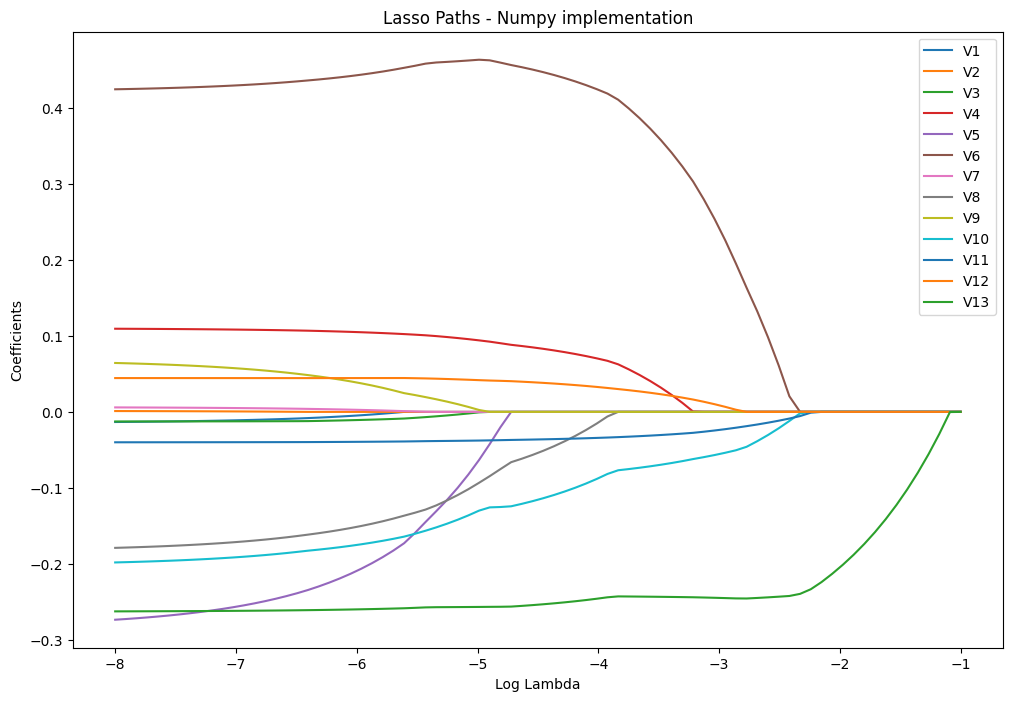

In [21]:
p, _ = myout.shape
plt.figure(figsize = (12,8))

for i in range(p-1):
    plt.plot(log_lam_seq, myout[i+1, :], label = var_names[i])

plt.xlabel('Log Lambda')
plt.ylabel('Coefficients')
plt.title('Lasso Paths - Numpy implementation')
plt.legend()
plt.axis('tight')

**Check the Accuracy**

Compare the accuracy of your algorithm against the output from glmnet. The maximum difference between the two coefficient matrices should be less than 0.005.

In [22]:
lasso_coef = pd.read_csv("Data/Coding2_lasso_coefs.csv").to_numpy()
lasso_coef.shape

(14, 80)

In [23]:
abs(myout - lasso_coef).max()

0.004645317415924666

### Part II: Simulation Study

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as lm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [16]:
# Load the datasets
data_case1 = pd.read_csv("Data/Coding2_Data2.csv")
data_case2 = pd.read_csv("Data/Coding2_Data3.csv")

In [17]:
class PCR(object):

    def __init__(self, num_folds=10):
        self.folds = num_folds

    def fit(self, X, Y):
        n, p = X.shape
        indices = np.arange(n)
        np.random.shuffle(indices)
        index_sets = np.array_split(indices, self.folds)
        ncomp = min(p, n - 1 - max([len(i) for i in index_sets]))
        cv_err = np.zeros(ncomp)

        for ifold in range(self.folds):
            train_inds =  np.delete(index_sets, obj=ifold, axis=0).ravel()
            test_inds = index_sets[ifold]

            X_train = X[train_inds, :]
            pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA())])
            pipeline.fit(X_train)
            X_train = pipeline.transform(X_train)
            coefs = Y[train_inds].T @ X_train / np.sum(X_train**2, axis=0)
            b0 = np.mean(Y[train_inds])

            X_test = pipeline.transform(X[test_inds, :])

            for k in np.arange(ncomp):
                preds = X_test[:, :k] @ coefs.T[:k] + b0
                cv_err[k] += cv_err[k] + np.sum((Y[test_inds]-preds)**2)

        min_ind = np.argmin(cv_err)
        self.ncomp = min_ind+1
        pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=self.ncomp))])
        self.transform = pipeline.fit(X)
        self.model = lm().fit(self.transform.transform(X), Y)

    def predict(self, X):
        X_ = self.transform.transform(X)
        return self.model.predict(X_)

In [18]:
def simulate_case_v1(data, num_iterations):
    num_procedures = 6

    mspe_results = np.zeros((num_iterations, num_procedures))
    Y_data = data['Y']
    X_data = data.drop(['Y'], axis = 1)

    for iteration in range(num_iterations):
        np.random.seed(722 + iteration)
        # Randomly split the data into training and testing sets
        n_case1 = len(Y_data)
        indices = np.arange(0, n_case1)
        np.random.shuffle(indices)
        test_ind_case1 = indices[:int(np.floor(0.25*n_case1))]
        train_ind_case1 = indices[len(test_ind_case1):]

        # Splitting the data into training and testing sets
        X_train = X_data.iloc[train_ind_case1]
        Y_train = Y_data[train_ind_case1]
        X_test = X_data.iloc[test_ind_case1]
        Y_test = Y_data[test_ind_case1]

        # Full Model
        full = lm().fit(X_train, Y_train)

        # Ridge Min
        ridge_alphas = np.logspace(-10, 1, 100)

        ridgecv = RidgeCV(alphas = ridge_alphas, cv = 10, scoring = 'neg_mean_squared_error')
        ridgecv_pipeline = Pipeline([('scaling', StandardScaler()), ('ridgecv', ridgecv)])
        ridgecv_pipeline.fit(X_train, Y_train)

        lambda_min = ridgecv_pipeline['ridgecv'].alpha_
        ridge_model = Ridge(alpha = lambda_min)
        ridge_pipeline = Pipeline([('scaling', StandardScaler()), ('ridge', ridge_model)])
        ridge_pipeline.fit(X_train, Y_train)

        # Lasso.min and Lasso.1se
        lasso_alphas = np.logspace(-10, 1, 100)
        lassocv = LassoCV(alphas = lasso_alphas, cv = 10)
        lassocv_pipeline = Pipeline([('scaling', StandardScaler()), ('lassocv', lassocv)])
        lassocv_pipeline.fit(X_train, Y_train)

        mean_mse = np.mean(lassocv_pipeline['lassocv'].mse_path_, axis=1)
        std_mse = np.std(lassocv_pipeline['lassocv'].mse_path_, axis=1) / np.sqrt(10)

        cv_alphas = lassocv_pipeline['lassocv'].alphas_
        min_idx = np.argmin(mean_mse)

        alpha_min = cv_alphas[min_idx]

        threshold = mean_mse[min_idx] + std_mse[min_idx]
        alpha_1se = max(cv_alphas[np.where(mean_mse <= threshold)])

        lasso_min_pipeline =  Pipeline([('scaling', StandardScaler()),
                                        ('lassomin', Lasso(alpha = alpha_min, max_iter=10000))])
        lasso_min_pipeline.fit(X_train, Y_train)

        lasso_1se_pipeline =  Pipeline([('scaling', StandardScaler()),
                                        ('lasso1se', Lasso(alpha = alpha_1se, max_iter=10000))])
        lasso_1se_pipeline.fit(X_train, Y_train)

        # L.refit
        nonzero_indices = np.where(lasso_1se_pipeline['lasso1se'].coef_ != 0)[0]
        lm_refit = lm()
        lm_refit.fit(X_train.iloc[:, nonzero_indices], Y_train)

        # PCR
        pcr = PCR()
        pcr.fit(X_train.to_numpy(), Y_train.to_numpy())

        procedures = [full, ridge_pipeline, lasso_min_pipeline, lasso_1se_pipeline, lm_refit, pcr]
        for i, procedure in enumerate(procedures):
            if i == 4:
                # lm_refit
                Y_pred = procedure.predict(X_test.iloc[:, nonzero_indices])
            else:
                Y_pred = procedure.predict(X_test)
            mspe = mean_squared_error(Y_test, Y_pred)
            mspe_results[iteration, i] = mspe
        print(mspe_results[iteration])

    return mspe_results

### Case I

In [19]:
mspe_case_v1 = simulate_case_v1(data_case1, 50)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.02314518 0.02553246 0.02576394 0.02776657 0.02647337 0.02661094]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.03286662 0.02896846 0.02972429 0.0323633  0.02795068 0.02699433]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.02662002 0.02148735 0.02119521 0.02406078 0.02214603 0.02054757]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.02063364 0.02079537 0.02112949 0.02739869 0.0252496  0.02211284]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.03936154 0.03442851 0.03556839 0.03599007 0.03695807 0.0416266 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.03267362 0.02787091 0.02920914 0.03224124 0.03067538 0.03037283]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.02507068 0.02847174 0.02543746 0.03358721 0.0292753  0.0294966 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.02480915 0.02100643 0.02195019 0.02398534 0.02405599 0.02455572]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.03946356 0.03384279 0.03449354 0.02935254 0.03067108 0.03952143]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.02690128 0.02906904 0.02959039 0.0349248  0.03220622 0.03024743]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.03641333 0.03134182 0.03181688 0.03380114 0.03733515 0.03385821]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.02108899 0.02185758 0.02321167 0.02748521 0.02409586 0.02564719]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.04082831 0.03126108 0.04255462 0.03769585 0.03523591 0.03679241]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.02921892 0.0283119  0.02824998 0.0350258  0.03273682 0.03239941]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.04245617 0.0221019  0.02385779 0.02858676 0.02701929 0.02446244]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.02341623 0.0245754  0.02471187 0.02493882 0.02822181 0.02742901]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.03836906 0.0284471  0.02875251 0.02837178 0.02636158 0.03733617]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.02802094 0.0274454  0.02685395 0.02826071 0.02908546 0.0275347 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.02375858 0.01918999 0.02180278 0.02389304 0.02496774 0.01994709]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.03798359 0.03247252 0.03403931 0.03155475 0.03604141 0.03595786]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.04148476 0.03173282 0.02549924 0.03350955 0.0293518  0.03921769]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.03305082 0.02781267 0.02937157 0.03439327 0.03137991 0.02804888]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.03596493 0.03009667 0.03055092 0.025963   0.03131522 0.03676954]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.0246011  0.02508147 0.02349036 0.03476847 0.03498098 0.02511343]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.02766971 0.02939009 0.03082121 0.03405811 0.03183095 0.03007067]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.02658422 0.02334669 0.02187475 0.02649452 0.02529719 0.02543775]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.03342319 0.0318452  0.03103088 0.03294251 0.03080399 0.03274203]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.02884009 0.03057563 0.02960826 0.03260505 0.0312401  0.02975848]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.02148467 0.01884159 0.01999636 0.02822764 0.0266481  0.02043878]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.02439761 0.01916689 0.01914733 0.02557998 0.02350494 0.02279725]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.02497448 0.01946717 0.02378294 0.02393322 0.02089764 0.0184716 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.04349689 0.03996422 0.04200535 0.04292093 0.04044387 0.04587733]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.03894229 0.03499002 0.03732877 0.04024645 0.04000543 0.03720352]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.02816126 0.01891682 0.02432004 0.02681961 0.02553538 0.02571749]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.03178808 0.02971212 0.02972728 0.03841854 0.03463923 0.03000199]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.03259775 0.02429056 0.0220391  0.02814285 0.02819068 0.03042126]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.03129657 0.0237724  0.0250435  0.0272739  0.02714673 0.02568056]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.02304534 0.02640211 0.02561933 0.03050137 0.02664822 0.03022331]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.0338229  0.03199939 0.03346642 0.03679483 0.03796234 0.03232457]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.03023725 0.02787262 0.02698007 0.02583453 0.02818885 0.02766442]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.02486644 0.02230273 0.02211598 0.02545326 0.02365763 0.0237526 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.03856046 0.03513935 0.03761298 0.02926908 0.03013908 0.02960492]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.03352327 0.02598227 0.02658964 0.02848389 0.02755763 0.02620657]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.02052611 0.02129147 0.01966831 0.03095712 0.02931679 0.02458838]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.03384521 0.02952833 0.03086462 0.03077766 0.03290118 0.03211484]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.034908   0.02292382 0.02294845 0.02354696 0.02419351 0.0290667 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.03208748 0.02182702 0.02301029 0.02796084 0.0234641  0.02443442]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.03538724 0.03123554 0.03185391 0.03204477 0.03413721 0.03211548]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.0276294  0.02569794 0.026808   0.03077621 0.03138813 0.02837076]
[0.02795143 0.02935471 0.02955428 0.03525973 0.0310026  0.03091379]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [20]:
with open('Data/mspe_case1.npy', 'wb') as f:
    np.save(f, mspe_case_v1)

In [9]:
columns = ['Full','Ridge.min','Lasso.min','Lasso.1se','L.Refit','PCR']
df_case1 = pd.DataFrame(mspe_case_v1, columns=columns)

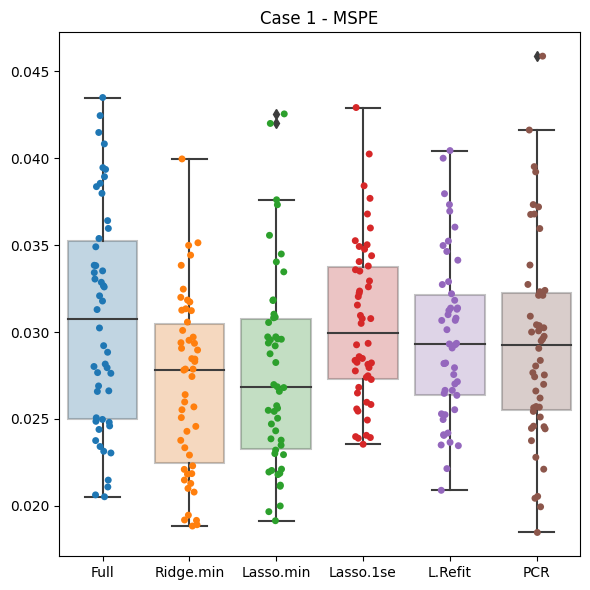

In [10]:
fig = plt.figure(figsize=(6, 6))
sns.stripplot(data=df_case1, jitter=True)
sns.boxplot(data=df_case1, boxprops=dict(alpha=.3))
plt.title("Case 1 - MSPE")
plt.tight_layout()

**Which procedure or procedures yield the best performance in terms of MSPE?**

Lasso.min

**Conversely, which procedure or procedures show the poorest performance?**

Full model

**In the context of Lasso regression, which procedure, Lasso.min or Lasso.1se, yields a better MSPE?**

Lasso.min

**Is refitting advantageous in this case? In other words, does L.Refit outperform Lasso.1se?**

Yes

**Is variable selection or shrinkage warranted for this particular dataset? To clarify, do you find the performance of the Full model to be comparable to, or divergent from, the best-performing procedure among the other five?**

The full model is not as good as the best-performing model, which is Lasso.min. Therefore both variable selection and shrinkage are warranted for this dataset.

### Case II

In [ ]:
mspe_case_v2 = simulate_case_v1(data_case2, 50)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.29302878 0.1065808  0.03665189 0.03665264 0.03898246 0.04702858]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.25185693 0.10907091 0.03852041 0.0370567  0.03973948 0.05281354]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.21616842 0.0922875  0.04299784 0.04661992 0.0451827  0.06466492]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.20226985 0.11400804 0.03991391 0.04564164 0.04106809 0.06225019]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.2542128  0.10083639 0.05050453 0.05187501 0.05506643 0.06766213]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.18152989 0.10853226 0.04696392 0.04957365 0.05062561 0.0616399 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.20945882 0.1069546  0.050155   0.05088966 0.05106558 0.06213468]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.23590041 0.10268474 0.03891233 0.04546651 0.04338628 0.04553998]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.28848497 0.11310588 0.04829118 0.05715339 0.05272916 0.06732938]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.29682693 0.09998092 0.04783019 0.05299573 0.05136054 0.05884481]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.26699103 0.09437023 0.04210204 0.04454521 0.0437052  0.04811338]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.29499032 0.09752761 0.03683323 0.04090375 0.03497809 0.0522193 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.25850391 0.1122206  0.04850475 0.0524699  0.04699632 0.05693835]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.21043698 0.1011059  0.05548153 0.0625864  0.06098284 0.07285345]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.27809845 0.09228248 0.03248571 0.0403317  0.03531044 0.0479794 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.193023   0.09667195 0.03892479 0.04808223 0.04231654 0.0606593 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.19320265 0.1120434  0.04599393 0.05083929 0.05035481 0.055104  ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.28168196 0.09134393 0.04341937 0.04461381 0.04554263 0.05382672]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.24535336 0.12400135 0.03049139 0.03485632 0.03093039 0.06050078]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.31703682 0.11771676 0.03654105 0.04380905 0.04582481 0.05550754]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.25259613 0.10413204 0.04672411 0.04651033 0.04946273 0.07412281]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.22536848 0.12054109 0.05183942 0.05682383 0.05532111 0.06886693]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.19200731 0.09412621 0.036037   0.03747544 0.03587739 0.04828125]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.15340605 0.10699715 0.04292147 0.04299952 0.04559636 0.04997876]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.19658008 0.109188   0.05264659 0.06133673 0.04807759 0.06046628]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.29815418 0.10458496 0.03841729 0.03813595 0.04064146 0.04768775]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.25530061 0.10397082 0.05207195 0.05827606 0.04990165 0.0699724 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.24494865 0.10509842 0.03900636 0.04015805 0.04504907 0.04561848]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.2639514  0.10083773 0.03841638 0.0497734  0.04166513 0.05458762]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.16623776 0.10042834 0.03721054 0.04392193 0.03824934 0.07408907]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.27086246 0.10811702 0.03971773 0.04424983 0.03728804 0.04883752]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.24652049 0.10270746 0.05216591 0.05564819 0.0560462  0.07338784]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.2217098  0.09807632 0.05633842 0.05922461 0.05606604 0.06365165]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.20994432 0.10669943 0.03797928 0.047765   0.03779638 0.05718709]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.23263829 0.09877765 0.05406228 0.05820213 0.05218078 0.0711233 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.20685348 0.10112106 0.04418557 0.0444161  0.04376239 0.05369643]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.23126049 0.09517516 0.03802522 0.04767022 0.04086273 0.05312845]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.22215612 0.13104883 0.04761119 0.05263239 0.04293067 0.06596828]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.20891142 0.10018662 0.05835267 0.06092835 0.06479839 0.07453403]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.25409176 0.10886196 0.04050826 0.04153725 0.04117106 0.05606932]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.29140758 0.09594145 0.03398039 0.03559178 0.03706238 0.04671387]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[0.23078177 0.10862127 0.03663589 0.03827368 0.03937132 0.0458519 ]


In [ ]:
with open('Data/mspe_case2.npy', 'wb') as f:
    np.save(f, mspe_case_v2)

In [12]:
columns = ['Full','Ridge.min','Lasso.min','Lasso.1se','L.Refit','PCR']
df_case2 = pd.DataFrame(mspe_case_v2, columns=columns)
df_case2 = df_case2.drop(['Full'], axis=1)

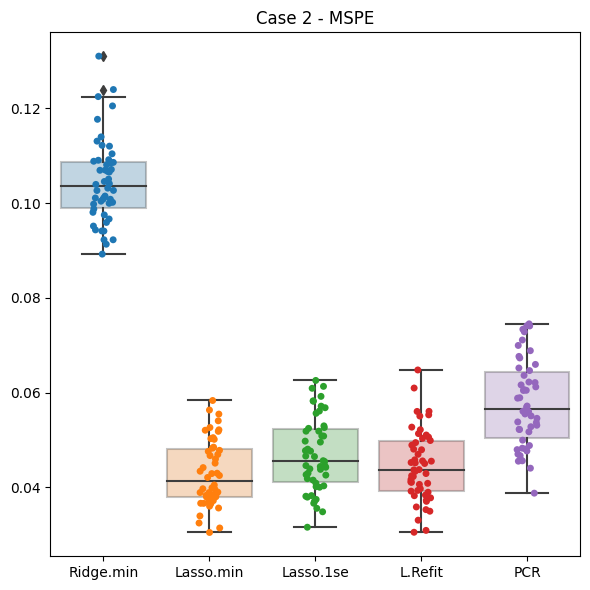

In [13]:
fig = plt.figure(figsize=(6, 6))
sns.stripplot(data=df_case2, jitter=True)
sns.boxplot(data=df_case2, boxprops=dict(alpha=.3))
plt.title("Case 2 - MSPE")
plt.tight_layout()

**Which procedure or procedures yield the best performance in terms of MSPE?**

Lasso.min

**Conversely, which procedure or procedures show the poorest performance?**

Ridge.min

**Have you observed any procedure or procedures that performed well in Case I but exhibited poorer performance in Case II, or vice versa? If so, please offer an explanation.**

All procedures performed worse in Case II, because there are artificially generated noise in Case II and it is more difficult to learn the data.

**Given that Coding2_Data3.csv includes all features found in Coding2_Data2.csv, one might anticipate that the best MSPE in Case II would be equal to or lower than the best MSPE in Case I. Do your simulation results corroborate this expectation? If not, please offer an explanation.**

No, because it is difficult for the models to learn exactly which features are relevant and which ones are noise. So even the feature selection models will assign some non-zero weights to some noise features and degrade performance.